In [1]:
pip install -e.

Obtaining file:///C:/Users/PC/OneDrive%20-%20UNIST%20%281%29/%EB%B0%94%ED%83%95%20%ED%99%94%EB%A9%B4/time-aware-pbpmNote: you may need to restart the kernel to use updated packages.

  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src


In [2]:
#Import Libraries
import os
#Change Directory to root
os.chdir('..')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
import sklearn
from src.Data.Datahandler import Datahandler
from src.Features.ComputeCW import *
from src.Features.Preprocess import *
from src.Hyperparameter.Hyperparameter import *
from src.Models.Model import *
from tensorboard.plugins.hparams import api as hp
import pickle

In [3]:
#Restart the kernel and re-run the whole notebook incase the directory location is not correct
#Reading the Data
#Enter the name of the dataset from the data/processed section: 
eventlog = "helpdesk.csv"
F = Datahandler()
name = F.read_data(eventlog)

In [4]:
spamreader,max_task = F.log2np()
D=Preprocess()
divisor,divisor2,divisor3 = D.divisor_cal(spamreader)
maxlen,chars,target_chars,char_indices,indices_char,target_char_indices,target_indices_char= D.dict_cal()
num_features = len(chars)+5
X,y_a,y_t,d_t=D.training_set(num_features)

Number of Unique Activities 9
divisor: 210915.5199854121
divisor2: 409874.9012399708
divisor3: 405646.8071511121
maxlen 15
['!', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª']
total chars: 9, target chars: 10
charecter_indices {'¢': 1, '£': 2, '¤': 3, '¥': 4, '¦': 5, '§': 6, '¨': 7, '©': 8, 'ª': 9}
nb sequences: 9181
num features: 14


In [5]:
df = pd.read_csv('C:/Users/PC/OneDrive - UNIST (1)/바탕 화면/time-aware-pbpm/data/processed/helpdesk.csv')
df.head()

,CaseID,ActivityID,CompleteTimestamp
0,2,1,2012-04-03 16:55:38
1,2,8,2012-04-03 16:55:53
2,2,6,2012-04-05 17:15:52
3,3,1,2010-10-29 18:14:06
4,3,8,2010-11-04 01:16:11


In [6]:
#Some Statistics of the data
spamread=F.spamread
x=spamread.groupby('CaseID')['ActivityID'].apply(list)
(unique, counts) = np.unique(x, return_counts=True)
spamread['CompleteTimestamp']=pd.to_datetime(spamread['CompleteTimestamp'],dayfirst=True)
spamread['diff'] = spamread.sort_values(['CaseID','CompleteTimestamp']).groupby('CaseID')['CompleteTimestamp'].diff()
spamread['duration'] = spamread.groupby('CaseID')['diff'].transform('sum')



##HelpDesk Dataset
print('Dataset',name)
print('Number of Instances:',len(spamread.groupby(['CaseID']).count()))
print('Case_Variant:',len(unique))
print('Unique Activities:',len(spamread['ActivityID'].unique()))
print('Events:',len(spamread))
print('Average Case length:',np.mean(spamread.groupby(['CaseID'])['ActivityID'].count()))
print('Maximum Case length:',np.max(spamread.groupby(['CaseID'])['ActivityID'].count()))
print('Minimum Case length:',np.min(spamread.groupby(['CaseID'])['ActivityID'].count()))
print('Max time per case:',spamread['duration'].max())
print('Min time per case:',spamread['duration'].min())
print('Average time per case:',spamread['duration'].mean())

Dataset helpdesk
Number of Instances: 3804
Case_Variant: 154
Unique Activities: 9
Events: 13710
Average Case length: 3.6041009463722395
Maximum Case length: 14
Minimum Case length: 1
Max time per case: 55 days 22:15:16
Min time per case: 0 days 00:00:00
Average time per case: 10 days 06:05:13.897155


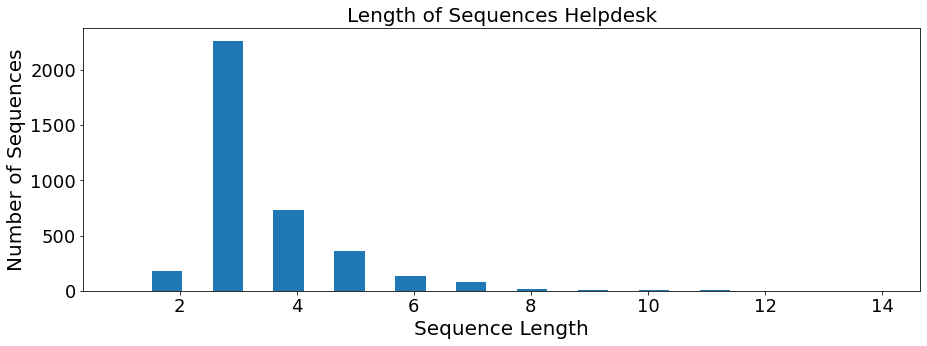

In [7]:
Step_length=spamread.groupby('CaseID')['ActivityID'].count()
Step_length = pd.DataFrame({'CaseID':Step_length.index, 'Steps':Step_length.values})
hist  = Step_length['Steps'].tolist()
f=plt.figure(figsize=[15,5])
plt.gcf().subplots_adjust(bottom=0.15)
plt.hist(hist , bins = 25)
#plt.xlim(left = 0, right = 20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Sequence Length',fontsize=20)
plt.ylabel('Number of Sequences',fontsize=20)
plt.title('Length of Sequences Helpdesk',fontsize=20)
plt.show()

Text(0, 0.5, 'Number of Occurances')

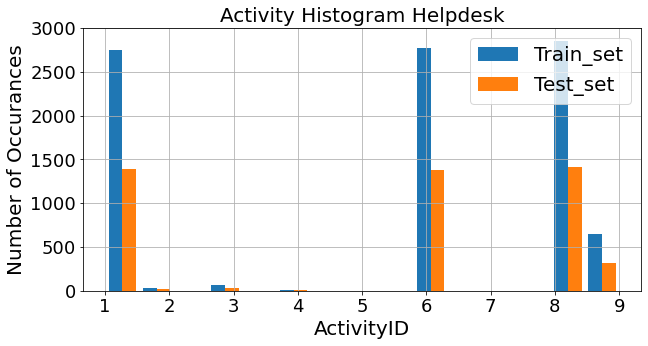

In [8]:
Dataset=pd.DataFrame(spamread.groupby('CaseID')['ActivityID'].apply(pd.Series))
Train_1,Train_2,Test=np.array_split(Dataset, 3)
Train = pd.concat([Train_1,Train_2])
hist1  = Train['ActivityID'].tolist()
hist2 = Test['ActivityID'].tolist()
f=plt.figure(figsize=[10,5])
plt.gcf().subplots_adjust(bottom=0.15)
plt.hist([hist1,hist2],bins=15,label=['Train_set','Test_set'])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title("Activity Histogram Helpdesk",fontsize=20)
plt.legend(loc='upper right',fontsize=20)
plt.xlabel('ActivityID',fontsize=20)
plt.ylabel('Number of Occurances',fontsize=20)

In [9]:
#Selectbest Hyperparameter_Tuning
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.0]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['nadam']))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.01]))


#Model Selection
model_choice = input( "Please Select model: 1.Class_Weighted, 2.TLSTM, 3.CS_TLSTM:")



if model_choice == '1':
    cw = ComputeCW()
    class_weights = cw.compute_class_weight(F.spamread)
    print('class_weights are: ', class_weights)


    def run(hparams):
        M = CSModel(maxlen,
                    max_task,
                    target_chars,
                    name,
                    num_features)
        M.train(X, y_a, y_t, class_weights, hparams,
                HP_NUM_UNITS, HP_DROPOUT,HP_OPTIMIZER, HP_LEARNING_RATE)

elif model_choice == '2':
    def run(hparams):
        M=ALL_TLSTM_Model(maxlen,
                          max_task,
                          target_chars,
                          name,
                          num_features)
        M.train(X,d_t,y_a,y_t,
                hparams,HP_NUM_UNITS,HP_DROPOUT,
                HP_OPTIMIZER,HP_LEARNING_RATE,epochs=5)

elif model_choice == '3':
    cw = ComputeCW()
    class_weights = cw.compute_class_weight(F.spamread)
    print('class_weights are: ', class_weights)
    def run(hparams):
        M = CS_TLSTM_Model(maxlen,
                            max_task,
                            target_chars,
                            name,
                            num_features)
        M.train(X, d_t, y_a, y_t, class_weights,
                hparams, HP_NUM_UNITS, HP_DROPOUT,
                HP_OPTIMIZER, HP_LEARNING_RATE)


for num_units in (HP_NUM_UNITS.domain.values):
    for dropout_rate in (HP_DROPOUT.domain.values):
        for optimizer in HP_OPTIMIZER.domain.values:
            for learning_rate in HP_LEARNING_RATE.domain.values: 
                hparams = {
                  HP_NUM_UNITS:num_units,
                  HP_DROPOUT: dropout_rate,
                  HP_OPTIMIZER: optimizer,
                  HP_LEARNING_RATE:learning_rate,
              }

                run_stat={h.name: hparams[h] for h in hparams}
                run_name = str(run_stat.values())

                print(run_stat)
                run(hparams)

{'num_units': 64, 'dropout': 0.0, 'optimizer': 'nadam', 'learning_rate': 0.01}
Build model...
Model will be saved at: c:\Users\PC\OneDrive - UNIST (1)\Model\2.TLSTM\TLSTM_lr_0.01_units_64_DO_0.0_helpdesk_{epoch:02d}-{val_loss:.2f}.h5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 15, 14)]     0                                            
__________________________________________________________________________________________________
delta_ts (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
tlstm_layer (TLSTM_layer)       (None, 15, 64)       24384       main_input[0][0]                 
__________________________________________________________

In [10]:
#Import Libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
from src.Data.Datahandler import Datahandler
from src.Features.ComputeCW import *
from src.Features.Preprocess import *
from src.Hyperparameter.Hyperparameter import *
from src.Models.Model import *
from src.Models.Test import NextStep #, Remaining_Step
from src.Evaluates.Evaluate import Nextstep_eval #,Remainstep_eval
from tensorboard.plugins.hparams import api as hp
import pickle

In [11]:
#Import data from file
os.chdir('..')
#Restart the kernel and re-run the whole notebook incase the directory location is not correct


#Reading the Data
#Enter the name of the dataset from the data/processed section: 
eventlog='helpdesk.csv'
F = Datahandler()
name=F.read_data(eventlog)

In [12]:
F = Datahandler()
name=F.read_data(eventlog)
#Model/TLSTM/Bas_helpdesk01-1.86.h5
model_name=input("Enter the model path e.g model/sub_path/model_name.h5: ")
print('  ')
#Reading the Data


num_features=14
spamreader,max_task = F.log2np()
D=Preprocess()
divisor,divisor2,divisor3 = D.divisor_cal(spamreader)
maxlen,chars,target_chars,char_indices,indices_char,target_char_indices,target_indices_char= D.dict_cal()
lines,caseids,lines_t,lines_t2,lines_t3=D.test_set()
test=input('Enter 1 for next_step eval: ')

if test =='1':        
    Nxt=NextStep(lines,caseids,lines_t,
                 lines_t2,lines_t3,maxlen,
                 eventlog,chars,target_chars,
                 divisor,divisor2,target_indices_char,
                 char_indices,model_name, num_features)
    print('Running Test')
    Nxt.test()

  
Number of Unique Activities 9
divisor: 210915.5199854121
divisor2: 409874.9012399708
divisor3: 405646.8071511121
maxlen 15
['!', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª']
total chars: 9, target chars: 10
charecter_indices {'¢': 1, '£': 2, '¤': 3, '¥': 4, '¦': 5, '§': 6, '¨': 7, '©': 8, 'ª': 9}
Running Test
2
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! predicted, end case
! 

In [13]:
os.chdir('..')
#Restart the kernel and re-run the whole notebook incase the directory location is not correct

Eval=input('For Nextstep_Evaluation Enter 1:  ')
print('  ')

#Results/next_activity_and_time_8.Baselinehelpdesk.csv
filename = input("Enter the next_step file name of the format:Results/filename.csv' : ") 
print('  ')

   CaseID  Prefix length Ground truth Predicted  Confidence  Levenshtein  \
0    3087              2           Â§        Â§        64.0          1.0   
1    3088              2           Â©        Â©        90.0          1.0   
2    3089              2           Âª        Â§        62.0          0.0   
3    3090              2           Â§        Â§        62.0          1.0   
4    3091              2           Â§        Â§        63.0          1.0   

   Damerau  Jaccard  Ground truth times  Predicted times  RMSE            MAE  
0      1.0      1.0              256462     58683.917704   NaN  197778.082296  
1      1.0      1.0                  14     16833.338303   NaN   16819.338303  
2      0.0      0.0              355698     65036.775013   NaN  290661.224987  
3      1.0      1.0                1800     43339.336854   NaN   41539.336854  
4      1.0      1.0              511775     32601.646417   NaN  479173.353583  

Prefix_Length 2
Number of Cases= 15704
Average Error= 3.214618

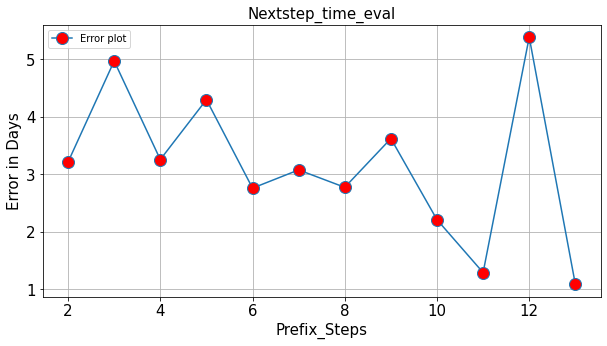


Prefix_Length 2
Number of Cases= 15704
Accuracy= 76.36907794192562 %

Prefix_Length 3
Number of Cases= 5885
Accuracy= 52.76125743415463 %

Prefix_Length 4
Number of Cases= 2703
Accuracy= 69.51535331113577 %

Prefix_Length 5
Number of Cases= 1141
Accuracy= 65.6441717791411 %

Prefix_Length 6
Number of Cases= 543
Accuracy= 73.48066298342542 %

Prefix_Length 7
Number of Cases= 190
Accuracy= 64.21052631578948 %

Prefix_Length 8
Number of Cases= 111
Accuracy= 57.65765765765766 %

Prefix_Length 9
Number of Cases= 64
Accuracy= 53.125 %

Prefix_Length 10
Number of Cases= 35
Accuracy= 65.71428571428571 %

Prefix_Length 11
Number of Cases= 17
Accuracy= 76.47058823529412 %

Prefix_Length 12
Number of Cases= 8
Accuracy= 100.0 %

Prefix_Length 13
Number of Cases= 4
Accuracy= 100.0 %

Overall Accuracy 71.2457151144008
Overall Weighted Accuracy 69.65726188221927


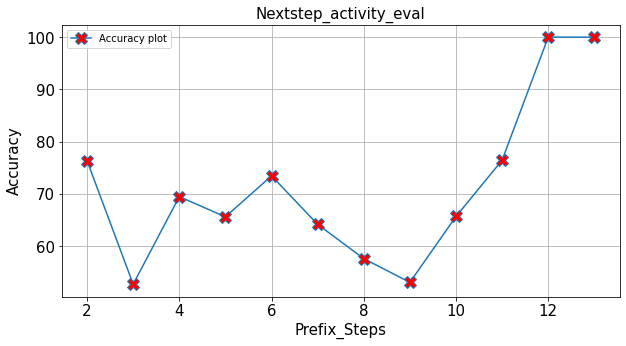

In [14]:
if Eval == '1':
    try:
        Ev=Nextstep_eval(filename)
        Ev.read()
        act_time=input("For time evaluations Enter 1, For activity related evaluations enter 2, Enter 3 for both: ")
        if act_time=='1':
            Ev.time()
        elif act_time=='2':
            Ev.activities()
        elif act_time=='3':
            Ev.time()
            Ev.activities()
    except IOError as e:
        errno, strerror = e.args
        print("I/O error({0}): {1}".format(errno,strerror))     

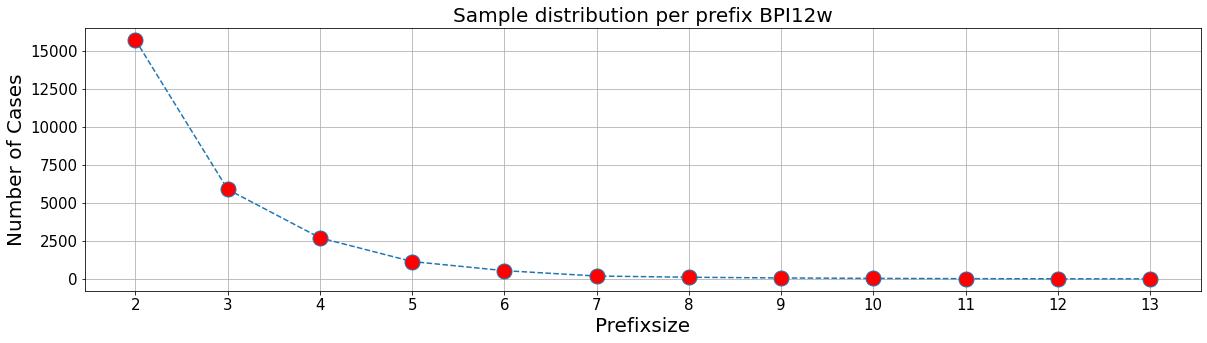

In [17]:
df=Ev.df
counter=[]
pre=[]
for i in df['Prefix length'].unique():
    #print('')
    #print('Prefix_Length',i )
    pre.append(i)
    x= df[df['Prefix length']==i]
    Wrong=x[x['Ground truth']!=x['Predicted']].count()[0]
    Correct=x[x['Ground truth']==x['Predicted']].count()[0]
    Total=x.count()[0]
    counter.append(Total)
    Accuracy=(Correct/Total)*100
g=plt.figure(figsize=[20,5])
plt.gcf().subplots_adjust(bottom=0.15)
plt.xticks(pre)
plot3=plt.plot(pre,counter,'--',marker='o',markerfacecolor='r',markersize=15)
plt.title('Sample distribution per prefix BPI12w',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.xlabel('Prefixsize',fontsize=20)
plt.ylabel('Number of Cases',fontsize=20)
plt.show()